# Overview

##### - Di notebook ini, akan dilakukan Feature Engineering dan Modelling yang akan memberikan output berupa model ML yang dapat digunakan untuk memprediksi kemungkinan nasabah yang gagal bayar. Model ini nantinya akan membantu tim underwriting fintech/bank untuk membantu proses persetujuan pinjaman.
##### - Model akan dievaluasi menggunakan metriks evaluasi yang relevan untuk meningkatkan keandalan dari sistem ini

### Import library yang digunakan

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder,StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split,cross_val_score
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix, f1_score,precision_score,recall_score,roc_auc_score,accuracy_score
import optuna
from functools import partial

Load data clean hasil Cleaning dan EDA

In [544]:
df = pd.read_csv("..\\data\\german_credit_data_clean.csv")
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk,age_bin,credit_bin,duration_bin
0,67,male,2,own,Unknown,little,1169,6,radio/TV,0,"(60, 100]",very low,<=12
1,22,female,2,own,little,moderate,5951,48,radio/TV,1,"(18, 25]",mid,37–48
2,49,male,1,own,little,Unknown,2096,12,education,0,"(40, 50]",low,<=12
3,45,male,2,free,little,little,7882,42,furniture/equipment,0,"(40, 50]",mid,37–48
4,53,male,2,free,little,little,4870,24,car,1,"(50, 60]",low,13-24


### Hal yang perlu dilakukan
- Encoding data kategorikal
- Pertimbangkan penggunaan log transform
- Scaling data numerik
- Feature interactions
- Feature importances

In [545]:
df['Risk'].value_counts()

Risk
0    700
1    300
Name: count, dtype: int64

##### Melakukan split untuk memisahkan data training dan data testing

In [620]:
X = df.drop('Risk',axis=1)
y = df['Risk']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2,random_state=42,stratify=y)

##### Membangun transformer kolom dan juga pipeline preprocessing data untuk memastikan keefisienan dalam proses training dan testing model.

In [621]:
categorical_column = ['Sex','Housing','Saving accounts','Checking account','Purpose','age_bin','credit_bin','duration_bin']
numerical_column = ['Age','Credit amount','Duration']

def generate_pipeline(model=None,name=''):
    transformers = ColumnTransformer([
        ('column_encoder',OneHotEncoder(),categorical_column),
        ('numeric_scaler',StandardScaler(),numerical_column),
        # ('num',StandardScaler(),numerical_column)
    ])

    pipeline = Pipeline([
        ('transformer', transformers),
        ('sampler',RandomUnderSampler(random_state=42)),
        # ('sampler',SMOTE(random_state=42)),
        ('model',model),
    ])

    return pipeline

def train(X_train,y_train,model=None):
    pipeline = generate_pipeline(model=model)
    pipeline.fit(X_train,y_train)
    return pipeline

def test_evaluate(X_test,y_test,model=None):
    y_pred = model.predict(X_test)

    print(f'Acc: {accuracy_score(y_test,y_pred)}')
    print(f'F1: {f1_score(y_test,y_pred)}')
    print(f'Precision: {precision_score(y_test,y_pred)}')
    print(f'Recall: {recall_score(y_test,y_pred)}')
    print(f'ROC-AUC: {roc_auc_score(y_test,y_pred)}')
    print(classification_report(y_test,y_pred))
    heatmap(confusion_matrix(y_test,y_pred))

def heatmap(data, title=""):
    plt.figure(figsize=(5,3))
    sns.heatmap(data, annot=True, cmap='Blues', fmt='.2f')
    plt.title(title)
    plt.tight_layout()
    plt.show()

##### - Disini saya menggunakan undersampling dengan RandomUnderSampler untuk menangani imbalanced data.
##### - Setelah dilakukan trial dan error, undersampling memberikan hasil evaluasi yang lebih baik dibanding oversampling sehingga undersampling digunakan untuk sampler dalam pipeline.


#### Cross Validation Model untuk Comparison

In [622]:
pipelines = {'log_reg': LogisticRegression(random_state=42,class_weight='balanced'),
             'rf': RandomForestClassifier(random_state=42,class_weight='balanced'),
             }

for name,pipeline in pipelines.items():
    pipes = generate_pipeline(pipeline,name=name)
    scoref1 = cross_val_score(pipes,X,y,cv=10,scoring='f1')
    scorerocauc = cross_val_score(pipes,X,y,cv=10,scoring='roc_auc')
    print(f'Model: {name}')
    print(f'F1-Score per fold: {scoref1}')
    print(f'Rata-rata F1-Score: {scoref1.mean()}')
    print(f'ROC-AUC per fold: {scorerocauc}')
    print(f'Rata-rata ROC-AUC: {scorerocauc.mean()}\n')

Model: log_reg
F1-Score per fold: [0.58536585 0.57894737 0.55882353 0.57534247 0.58974359 0.63636364
 0.46575342 0.67532468 0.63888889 0.56410256]
Rata-rata F1-Score: 0.5868655996325668
ROC-AUC per fold: [0.76619048 0.73285714 0.75857143 0.7552381  0.77714286 0.78761905
 0.58619048 0.85285714 0.77095238 0.74285714]
Rata-rata ROC-AUC: 0.7530476190476191

Model: rf
F1-Score per fold: [0.56410256 0.53333333 0.59701493 0.56790123 0.56338028 0.63768116
 0.46575342 0.60759494 0.58666667 0.45945946]
Rata-rata F1-Score: 0.5582887985979885
ROC-AUC per fold: [0.73714286 0.73642857 0.74404762 0.7652381  0.68261905 0.79404762
 0.62357143 0.82785714 0.77404762 0.66666667]
Rata-rata ROC-AUC: 0.7351666666666666



In [623]:
def models(model_name, **params):
    if model_name == "rf":
        from sklearn.ensemble import RandomForestClassifier
        return RandomForestClassifier(**params,class_weight='balanced')
    elif model_name == "log_reg":
        from sklearn.linear_model import LogisticRegression
        return LogisticRegression(**params,class_weight='balanced')
    else:
        raise ValueError("Unknown model name")

#### Setup hyperparameter Tuning dengan optuna untuk model Logistic Regression dan Random Forest

In [624]:
def objective(trial,model_name=''):
    if model_name=='log_reg':
        params = {
            'C': trial.suggest_float('C', 1e-4, 1000,log=True),
            'solver': trial.suggest_categorical('solver', ['lbfgs', 'liblinear']),
            'max_iter': trial.suggest_int('max_iter', 100, 3500)
        }
    elif model_name=='rf':
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 500),
            'max_depth': trial.suggest_int('max_depth', 2, 32),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        }
    # Buat pipeline model
    model = generate_pipeline(
        model=models(model_name, **params)
    )

    # Cross-validation
    scores_f1 = cross_val_score(model, X, y, cv=5, scoring='f1')
    scores_roc = cross_val_score(model, X, y, cv=5, scoring='roc_auc')
    trial.set_user_attr('roc_auc', np.mean(scores_roc))
    return np.mean(scores_f1)

studylogreg = optuna.create_study(direction='maximize')
studylogreg.optimize(partial(objective,model_name='log_reg'), n_trials=30)
print(f'Best params : {studylogreg.best_params}')
print(f'Best F1 (CV):{studylogreg.best_value}')

[I 2025-05-30 21:39:04,836] A new study created in memory with name: no-name-4f556262-854f-45a0-855b-640244413b2a
[I 2025-05-30 21:39:05,381] Trial 0 finished with value: 0.5772052940236122 and parameters: {'C': 0.11590942207917472, 'solver': 'lbfgs', 'max_iter': 120}. Best is trial 0 with value: 0.5772052940236122.
[I 2025-05-30 21:39:05,786] Trial 1 finished with value: 0.5594144324396424 and parameters: {'C': 0.007156777879962831, 'solver': 'lbfgs', 'max_iter': 2634}. Best is trial 0 with value: 0.5772052940236122.
[I 2025-05-30 21:39:06,095] Trial 2 finished with value: 0.5715389001791084 and parameters: {'C': 0.18691822556078339, 'solver': 'liblinear', 'max_iter': 519}. Best is trial 0 with value: 0.5772052940236122.
[I 2025-05-30 21:39:06,392] Trial 3 finished with value: 0.5260667868519231 and parameters: {'C': 0.00012342049096935787, 'solver': 'liblinear', 'max_iter': 2760}. Best is trial 0 with value: 0.5772052940236122.
[I 2025-05-30 21:39:06,766] Trial 4 finished with value:

Best params : {'C': 950.6888483643759, 'solver': 'liblinear', 'max_iter': 1907}
Best F1 (CV):0.5823497106241753


In [625]:
study = optuna.create_study(direction='maximize')
study.optimize(partial(objective,model_name='rf'), n_trials=20)
print(f'Best params : {study.best_params}')
print(f'Best F1 (CV):{study.best_value}')

[I 2025-05-30 21:39:13,214] A new study created in memory with name: no-name-4bbfb082-87af-4b30-bb18-4b1c2f9bcfb6


[I 2025-05-30 21:39:14,948] Trial 0 finished with value: 0.5658370149747662 and parameters: {'n_estimators': 90, 'max_depth': 8, 'min_samples_split': 10, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.5658370149747662.
[I 2025-05-30 21:39:22,157] Trial 1 finished with value: 0.5663792204591072 and parameters: {'n_estimators': 359, 'max_depth': 22, 'min_samples_split': 8, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.5663792204591072.
[I 2025-05-30 21:39:29,266] Trial 2 finished with value: 0.562943533843846 and parameters: {'n_estimators': 347, 'max_depth': 27, 'min_samples_split': 8, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.5663792204591072.
[I 2025-05-30 21:39:35,470] Trial 3 finished with value: 0.570707951371051 and parameters: {'n_estimators': 365, 'max_depth': 14, 'min_samples_split': 8, 'min_samples_leaf': 8}. Best is trial 3 with value: 0.570707951371051.
[I 2025-05-30 21:39:39,951] Trial 4 finished with value: 0.5620441605069644 and parameters: {'n_

Best params : {'n_estimators': 104, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 7}
Best F1 (CV):0.5860759789810297


#### Dari kedua tuning yang dilakukan, F1 Score dari model Random Forest sedikit lebih baik dibanding model Logistic Regression. Selanjutnya dilakukan training model dan melakukan testing

#### Modelling baseline Logistic Regression

Acc: 0.695
F1: 0.6013071895424836
Precision: 0.4946236559139785
Recall: 0.7666666666666667
ROC-AUC: 0.7154761904761906
              precision    recall  f1-score   support

           0       0.87      0.66      0.75       140
           1       0.49      0.77      0.60        60

    accuracy                           0.69       200
   macro avg       0.68      0.72      0.68       200
weighted avg       0.76      0.69      0.71       200



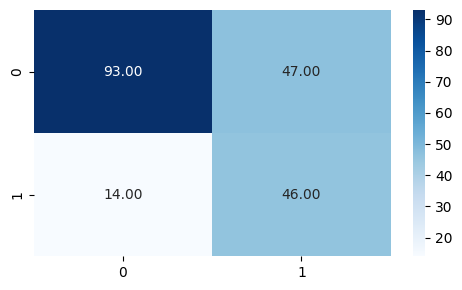

In [630]:
model_LogReg = train(X_train,y_train,LogisticRegression(random_state=42,class_weight='balanced')) 

test_evaluate(X_test,y_test,model_LogReg)

#### Modelling Logistic Regression + Hyperparameter Tuning

Acc: 0.685
F1: 0.5827814569536424
Precision: 0.4835164835164835
Recall: 0.7333333333333333
ROC-AUC: 0.6988095238095239
              precision    recall  f1-score   support

           0       0.85      0.66      0.75       140
           1       0.48      0.73      0.58        60

    accuracy                           0.69       200
   macro avg       0.67      0.70      0.66       200
weighted avg       0.74      0.69      0.70       200



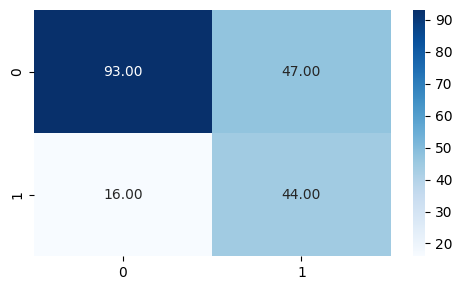

In [632]:
model_LogReg_tuned = train(X_train,y_train,LogisticRegression(random_state=42,class_weight='balanced',**studylogreg.best_params)) 

test_evaluate(X_test,y_test,model_LogReg_tuned)

#### Modelling baseline Random Forest

Acc: 0.69
F1: 0.5866666666666667
Precision: 0.4888888888888889
Recall: 0.7333333333333333
ROC-AUC: 0.7023809523809524
              precision    recall  f1-score   support

           0       0.85      0.67      0.75       140
           1       0.49      0.73      0.59        60

    accuracy                           0.69       200
   macro avg       0.67      0.70      0.67       200
weighted avg       0.74      0.69      0.70       200



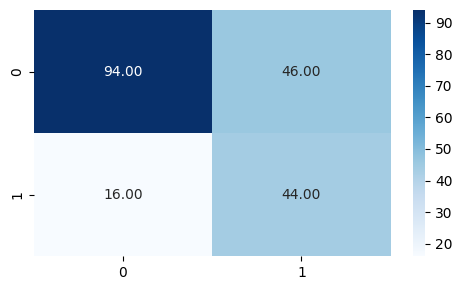

In [633]:
model_Rf = train(X_train,y_train,RandomForestClassifier(random_state=42,class_weight='balanced')) 

test_evaluate(X_test,y_test,model_Rf)

#### Modelling RF + Hyperparameter Tuning

Acc: 0.705
F1: 0.6289308176100629
Precision: 0.5050505050505051
Recall: 0.8333333333333334
ROC-AUC: 0.7416666666666668
              precision    recall  f1-score   support

           0       0.90      0.65      0.76       140
           1       0.51      0.83      0.63        60

    accuracy                           0.70       200
   macro avg       0.70      0.74      0.69       200
weighted avg       0.78      0.70      0.72       200



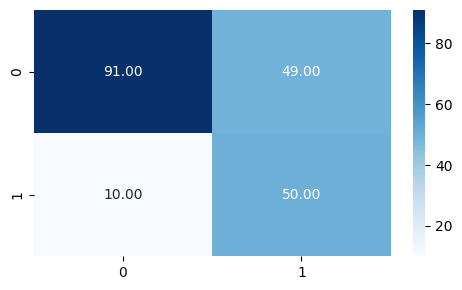

In [634]:
model_Rf_tuned = train(X_train,y_train,RandomForestClassifier(random_state=42,class_weight='balanced',**study.best_params)) 

test_evaluate(X_test,y_test,model_Rf_tuned)

#### Summary
- Hasil Menunjukkan Baseline model Logistic Regression sedikit lebih baik dibanding Random Forest.
- Untuk model yang menggunakan best_params dari tuning, model Random Forest mengalami peningkatan signifikan dari F1-Score yang awalnya 0.5694 menjadi 0.6163. Di sisi lain, model Logistic Regression justru mengalami penurunan

#### Selanjutnya akan berfokus pada model Random Forest. Disini akan dilakukan treshold tuning untuk menemukan treshold optimal dengan F1-Score tertinggi

In [635]:
thresholds = np.arange(0,100,0.02)
f1_scores = []

y_proba = model_Rf_tuned.predict_proba(X_test)[:,1]
for thr in thresholds:
    y_pred_thr = (y_proba>=thr).astype('int')
    scores = f1_score(y_pred_thr,y_test)
    f1_scores.append(scores)

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]
print(f"Best threshold: {best_threshold:.2f} | Best F1-score: {best_f1:.4f}")

Best threshold: 0.48 | Best F1-score: 0.6375


#### Insight
- Setelah dilakukan modelling, hyperparameter tuning, serta treshold  tuning, didapat model terbaik yakni Random Forest dengan parameter 
    - 'n_estimators': 104
    - 'max_depth': 8
    - 'min_samples_split': 9
    - 'min_samples_leaf': 7
- Model ini mendapat skor metriks F1-Score yakni 0.6375 dimana treshold di sekitar 0.48. Dengan F1-Score 0.6375, performa model dalam menyeimbangkan prediksi apakah calon nasabah adalah good atau bad, serta kemampuan menangkap keseluruhan calon nasabah yang good sebesar 62.5 dari skala 1-100.
- Model ini akan membantu tim underwriting untuk membantu sebagai pertimbangan dalam mengapprove calon nasabah untuk kredit